# 임베딩 내 편향성 알아보기

## WEAT 구현하기

In [11]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

우선 두 개의 target 단어 셋 X, Y와 두 개의 attribute 단어 셋 A, B를 정의합니다.
단어 셋을 정할 때는 두 개의 target 셋의 크기가 같아야 하고, 두 개의 attribute 셋의 크기가 같아야 합니다.

###### targets
- X set(꽃) : 장미, 튤립, 백합, 데이지
- Y set(곤충) : 거미, 모기, 파리, 메뚜기

###### attributes
- A set(유쾌) : 사랑, 행복, 웃음
- B set(불쾌) : 재난, 고통, 증오
위 단어들의 임베딩 결과가 다음과 같다고 해봅시다.

In [12]:
target_X = {
    '장미': [4.1, 1.2, -2.4, 0.5, 4.1],
    '튤립': [3.1, 0.5, 3.6, 1.7, 5.8],
    '백합': [2.9, -1.3, 0.4, 1.1, 3.7],
    '데이지': [5.4, 2.5, 4.6, -1.0, 3.6]
}
target_Y = {
    '거미': [-1.5, 0.2, -0.6, -4.6, -5.3],
    '모기': [0.4, 0.7, -1.9, -4.5, -2.9],
    '파리': [0.9, 1.4, -2.3, -3.9, -4.7],
    '메뚜기': [0.7, 0.9, -0.4, -4.1, -3.9]
}
attribute_A = {
    '사랑':[2.8,  4.2, 4.3,  0.3, 5.0],
    '행복':[3.8,  3. , -1.2,  4.4, 4.9],
    '웃음':[3.7, -0.3,  1.2, -2.5, 3.9]
}
attribute_B = {
    '재난': [-0.2, -2.8, -4.7, -4.3, -4.7],
    '고통': [-4.5, -2.1, -3.8, -3.6, -3.1],
    '증오': [-3.6, -3.3, -3.5, -3.7, -4.4]
}


In [13]:
X = np.array([v for v in target_X.values()])
Y = np.array([v for v in target_Y.values()])
print(X)
print(Y)

[[ 4.1  1.2 -2.4  0.5  4.1]
 [ 3.1  0.5  3.6  1.7  5.8]
 [ 2.9 -1.3  0.4  1.1  3.7]
 [ 5.4  2.5  4.6 -1.   3.6]]
[[-1.5  0.2 -0.6 -4.6 -5.3]
 [ 0.4  0.7 -1.9 -4.5 -2.9]
 [ 0.9  1.4 -2.3 -3.9 -4.7]
 [ 0.7  0.9 -0.4 -4.1 -3.9]]


In [14]:
A = np.array([v for v in attribute_A.values()])
B = np.array([v for v in attribute_B.values()])
print(A)
print(B)

[[ 2.8  4.2  4.3  0.3  5. ]
 [ 3.8  3.  -1.2  4.4  4.9]
 [ 3.7 -0.3  1.2 -2.5  3.9]]
[[-0.2 -2.8 -4.7 -4.3 -4.7]
 [-4.5 -2.1 -3.8 -3.6 -3.1]
 [-3.6 -3.3 -3.5 -3.7 -4.4]]


In [15]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

print(s(target_X['장미'], A, B))

0.6457646122337399


WEAT score값이 양수이므로, target_X에 있는 '장미'라는 단어는 attribute_B(불쾌)보다 attribute_A(유쾌)와 더 가깝다는 것을 알 수 있습니다. target_Y에 있는 '거미'와 attribute_A, attribute_B와의 관계도 계산해봅시다.

In [16]:
print(s(target_Y['거미'], A, B))

-0.794002342033094


위와 반대로 WEAT score가 음수가 나왔으므로, '거미'는 attribute_B와 더 가깝다는 것을 알 수 있습니다.

그럼 target_X와 attribute_A, attribute_B 사의의 평균값, 그리고 target_Y와 attribute_A, attribute_B 사의의 평균값은 어떻게 될까요?

In [17]:
print(s(X, A, B))
print(round(np.mean(s(X, A, B)), 3))

[0.29551989 0.51723181 0.26499096 0.50924109]
0.397


target_X와 attribute_A, attribute_B 사이의 평균값은 0.397입니다.

In [18]:
print(s(Y, A, B))
print(round(np.mean(s(Y, A, B)), 3))

[-0.44713039 -0.28310853 -0.33144878 -0.26030641]
-0.33


target_Y와 attribute_A, attribute_B 사이의 평균값은 -0.33입니다.

그럼 이번에는 WEAT score의 수식 전체를 코드로 나타내 봅시다.

In [19]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

print(round(weat_score(X, Y, A, B), 3))

1.932


WEAT score가 매우 높게 나온 것을 알 수 있습니다. 즉, 꽃은 유쾌한 단어와 상대적으로 가깝고, 곤충은 불쾌한 단어와 가깝다는 것을 수치적으로 확인할 수 있었습니다.

이제 이를 시각적으로 확인해볼까요? PCA를 통해 5차원이었던 벡터를 2차원으로 줄여 그림을 그려보겠습니다.

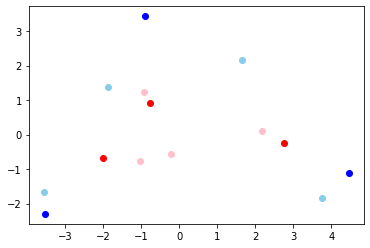

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A')
ax.scatter(pc_B[:,0],pc_B[:,1], c='red', label='B')
ax.scatter(pc_X[:,0],pc_X[:,1], c='skyblue', label='X')
ax.scatter(pc_Y[:,0],pc_Y[:,1], c='pink', label='Y')

## 사전학습된 Word Embedding에 WEAT 적용

In [1]:
import os

data_dir = '~/aiffel/weat' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

from gensim.models import KeyedVectors

# 50만개의 단어만 활용합니다. 메모리가 충분하다면 limit 파라미터값을 생략하여 300만개를 모두 활용할 수 있습니다. 
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)

In [2]:
w2v

w2v에 있는 단어 개수와 벡터 크기를 살펴볼까요?

💡 참고
2021년 3월, Gensim이 4.0 으로 버전업되면서 KeyedVectors에 vocab dict가 제거되었습니다. 상세한 내용은 아래 링크를 참고해 주세요.

Migrating from Gensim 3.x to 4

In [3]:
# print(len(w2v.vocab))   # Gensim 3.X 버전까지는 w2v.vocab을 직접 접근할 수 있습니다. 
print(len(w2v.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(w2v['I']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(w2v.vectors.shape)

500000
300
(500000, 300)


In [4]:
w2v['happy']

array([-5.18798828e-04,  1.60156250e-01,  1.60980225e-03,  2.53906250e-02,
        9.91210938e-02, -8.59375000e-02,  3.24218750e-01, -2.17285156e-02,
        1.34765625e-01,  1.10351562e-01, -1.04980469e-01, -2.90527344e-02,
       -2.38037109e-02, -4.02832031e-02, -3.68652344e-02,  2.32421875e-01,
        3.20312500e-01,  1.01074219e-01,  5.83496094e-02, -2.91824341e-04,
       -3.29589844e-02,  2.11914062e-01,  4.32128906e-02, -8.59375000e-02,
        2.81250000e-01, -1.78222656e-02,  3.79943848e-03, -1.71875000e-01,
        2.06054688e-01, -1.85546875e-01,  3.73535156e-02, -1.21459961e-02,
        2.04101562e-01, -3.80859375e-02,  3.61328125e-02, -8.15429688e-02,
        8.44726562e-02,  9.37500000e-02,  1.44531250e-01,  7.42187500e-02,
        2.51953125e-01, -7.91015625e-02,  8.69140625e-02,  1.58691406e-02,
        1.09375000e-01, -2.23632812e-01, -5.15747070e-03,  1.68945312e-01,
       -1.36718750e-01, -2.51464844e-02, -3.85742188e-02, -1.33056641e-02,
        1.38671875e-01,  

In [5]:
w2v.most_similar(positive=['happy'])

[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

In [6]:
w2v.most_similar(positive=['family'])

[('relatives', 0.6662653088569641),
 ('familiy', 0.6517067551612854),
 ('families', 0.6252894997596741),
 ('siblings', 0.6140849590301514),
 ('friends', 0.6128394603729248),
 ('mother', 0.6065612435340881),
 ('aunt', 0.5811319947242737),
 ('grandparents', 0.5762072205543518),
 ('father', 0.5717043876647949),
 ('Family', 0.5672314763069153)]

In [7]:
w2v.most_similar(positive=['school'])

[('elementary', 0.7868632078170776),
 ('schools', 0.7411909103393555),
 ('elementary_schools', 0.6597153544425964),
 ('kindergarten', 0.6529811024665833),
 ('eighth_grade', 0.6488089561462402),
 ('School', 0.6477997303009033),
 ('teacher', 0.63824063539505),
 ('students', 0.6301522850990295),
 ('classroom', 0.6281620264053345),
 ('Schools', 0.6172096133232117)]

In [21]:
target_X = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_Y = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_A = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_B = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.2624874

과학과 관련된 단어가 남성과 관련된 단어와 가깝고, 예술과 관련된 단어가 여성과 관련된 단어와 가깝게 나타났습니다. 사람의 편향성을 실험하는 IAT에서도 이와 같게 나타났었죠? 많은 사람이 가진 편향이 임베딩 모델에 반영되었다고 볼 수 있습니다.

이제 다른 셋을 구성해볼까요? target_X는 인스턴트 식품들로 단어를 구성하였고 target_Y는 그 반대로 구성했습니다. attribute_A는 인스턴트를 의미하는 단어들로, attributes_B는 그 반대로 구성했습니다.

이 단어 셋들을 보면 target_X는 attribute_A와 attribute_B 중 어떤 것과 가깝다고 생각하시나요?
보통 target_X와 attribute_A가 가깝고, traget_Y는 attribute_B와 가깝다고 대답할 것입니다.
임베딩 모델도 그렇게 생각할까요?

In [22]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['junk', 'canned', 'convenience', 'frozen', 'fast']
attribute_B = ['health', 'beneficial', 'good', 'nourishing', 'nutritious']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.6909266

모델도 우리의 예상과 맞는 방향으로 상당히 높은 수치를 보이는 것을 확인했습니다. 인스턴트 식품의 예시와 인스턴트를 의미하는 단어가 가까운 것은 당연합니다. 이 경우 모델이 편향되어있다기보다 단어의 의미를 잘 파악했다고 볼 수 있습니다.

동일한 target 셋에 다른 attribute 셋을 만들볼까요? attribute_A에는 책과 관련된 단어로 구성하고, attribute_B는 뉴스와 관련된 단어로 구성했습니다. 이번에는 어떤 결과를 가져올까요?

In [23]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['book', 'essay', 'dictionary', 'magazine', 'novel']
attribute_B = ['news', 'report', 'statement', 'broadcast', 'word']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

-0.05137869

0에 굉장히 가까운 결과를 보였습니다. 즉, 임베딩 모델이 판단하기에 어느 것끼리 가깝다고 말할 수 없는 것이지요.

여러분이 target, attribute 셋을 만들어서 WEAT score를 구해보세요.

In [24]:
target_X = ['student']
target_Y = ['teacher']
attribute_A = ['new']
attribute_B = ['old']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

2.0

In [25]:
#메모리를 다시 비워줍시다.
del w2v
print("삭제 완료")

삭제 완료


## 직접 만드는 Word Embedding에 WEAT 적용

지금까지는 제시된 모델과 단어들로 WEAT score를 구해보았습니다. 이제 주어진 데이터로 다음과 같은 과정을 수행해보도록 하겠습니다.

1. 형태소 분석기를 이용하여 품사가 명사인 경우, 해당 단어를 추출하기
2. 추출된 결과로 embedding model 만들기
3. TF/IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기
4. embedding model과 단어 셋으로 WEAT score 구해보기

## 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기
synopsis.txt(대략 17MB)에는 2001년부터 2019년 8월까지 제작된 영화들의 시놉시스 정보가 있습니다. (개봉된 영화 중 일부만 포함되어있습니다. 더 많은 영화 정보를 원하시면 KOBIS에서 확인하시기 바랍니다.) synopsis.txt의 일부를 읽어볼까요?

In [13]:
import os

In [15]:
with open('./synopsis/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [18]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print("슝~")

FileNotFoundError: [Errno 2] JVM DLL not found: /Library/Java/JavaVirtualMachines/adoptopenjdk-16.jdk/Contents/Home/lib/libjli.dylib

In [29]:
print(len(tokenized))

71156


## 2. 추출된 결과로 embedding model 만들기


In [30]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('작품', 0.8959430456161499),
 ('다큐멘터리', 0.8382184505462646),
 ('드라마', 0.8094937205314636),
 ('코미디', 0.8028953671455383),
 ('영화로', 0.7913675904273987),
 ('형식', 0.7841488718986511),
 ('감동', 0.7787631750106812),
 ('멜로', 0.7780297994613647),
 ('스토리', 0.7756514549255371),
 ('주제', 0.7682903409004211)]

In [31]:
model.wv.most_similar(positive=['사랑'])

[('만남', 0.7167994379997253),
 ('행복', 0.7143447399139404),
 ('이별', 0.7026219367980957),
 ('애정', 0.6968078017234802),
 ('첫사랑', 0.6957947611808777),
 ('연애', 0.6892619729042053),
 ('운명', 0.6876009106636047),
 ('실연', 0.6799206733703613),
 ('아르튬', 0.6772080659866333),
 ('진심', 0.6767643690109253)]

In [32]:
model.wv.most_similar(positive=['연극'])

[('영화감독', 0.8925940990447998),
 ('시나리오', 0.8844861388206482),
 ('배우', 0.8820911645889282),
 ('캐스팅', 0.8732603788375854),
 ('연기자', 0.8671134114265442),
 ('연기', 0.864342987537384),
 ('영감', 0.8641541004180908),
 ('대본', 0.8630951046943665),
 ('데뷔', 0.8609700798988342),
 ('무용', 0.8608227372169495)]

## 3. TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기

WEAT score를 구할 때 단어 셋을 만들어주어야 합니다. targets_X, targets_Y, attribute_A, attribute_B를 만들어주었던 것이 기억나시죠? 이제 두 축을 어떤 기준으로 잡고, 해당 축의 어떤 항목을 사용할지 정해야 합니다.

여기서는 두 축을 영화 장르, 영화 구분 정보를 이용하겠습니다. (영화 구분 정보란 일반영화, 예술영화, 독립영화로 구분된 정보입니다. KOBIS에서 제공한 정보를 기준으로 분류하였습니다.)

#### 영화 구분
- synopsis_art.txt : 예술영화
- synopsis_gen.txt : 일반영화(상업영화)
- 그 외는 독립영화 등으로 분류됩니다.

#### 장르 구분
- synopsis_SF.txt: SF
- synopsis_가족.txt: 가족
- synopsis_공연.txt: 공연
- synopsis_공포(호러).txt: 공포(호러)
- synopsis_기타.txt: 기타
- synopsis_다큐멘터리.txt: 다큐멘터리
- synopsis_드라마.txt: 드라마
- synopsis_멜로로맨스.txt: 멜로로맨스
- synopsis_뮤지컬.txt: 뮤지컬
- synopsis_미스터리.txt: 미스터리
- synopsis_범죄.txt: 범죄
- synopsis_사극.txt: 사극
- synopsis_서부극(웨스턴).txt: 서부극(웨스턴)
- synopsis_성인물(에로).txt: 성인물(에로)
- synopsis_스릴러.txt: 스릴러
- synopsis_애니메이션.txt: 애니메이션
- synopsis_액션.txt: 액션
- synopsis_어드벤처.txt: 어드벤처
- synopsis_전쟁.txt: 전쟁
- synopsis_코미디.txt: 코미디
- synopsis_판타지.txt: 판타지

이번에는 예술영화와 일반영화(상업영화)라는 영화구분을 target으로 삼고, 드라마 장르와 액션 장르라는 장르구분을 attribute로 삼아 WEAT score를 계산해 보겠습니다. 즉 드라마 장르에는 예술영화적 성격이 강하고, 액션 장르에는 일반(상업)영화적 성격이 강할 것이라는 편향성이 워드 임베딩 상에 얼마나 나타나고 있는지를 측정해 보겠다는 것입니다.

'synopsis_art.txt', 'synopsis_gen.txt' 두 파일을 읽고, 위에서 했던 것과 마찬가지로 명사에 대해서만 추출하여 art, gen 변수에 할당하시기 바랍니다.

In [ ]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

print("슝~")

In [ ]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

In [ ]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

In [ ]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

어떤가요? 두 개념을 대표하는 단어를 TF-IDF가 높은 순으로 추출하고 싶었는데, 양쪽에 중복된 단어가 너무 많은 것을 볼 수 있습니다. 두 개념축이 대조되도록 대표하는 단어 셋을 만들고 싶기 때문에 단어가 서로 중복되지 않게 단어셋을 추출해야 합니다. 우선 상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출합니다.

In [ ]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [ ]:
print(target_art)

In [ ]:
print(target_gen)

이번에는 장르별 대표 단어를 추출해 봅시다. 이번에는 드라마 장르와 액션 장르를 다루어 보려고 합니다. 그러나 드라마와 액션 단 2개의 장르만 고려하기보다는 여러 장르의 코퍼스를 두루 고려하는 것이 특정 장르를 대표하는 단어를 선택하는 데 더 유리할 것입니다. 이번에는 주요 장르 5개만 고려해 봅시다.

In [ ]:
genre_txt = ['synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_action.txt', 'synopsis_comedy.txt', 'synopsis_war.txt', 'synopsis_horror.txt']
genre_name = ['드라마', '멜로로맨스', '액션', '코미디', '전쟁', '공포(호러)']

print("슝~")

In [ ]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

In [ ]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

## 4. embedding model과 단어 셋으로 WEAT score 구해보기

이제 WEAT_score를 구해봅시다.

traget_X는 art, target_Y는 gen, attribute_A는 '드라마', attribute_B는 '액션' 과 같이 정해줄 수 있습니다.

target_X 는 art, target_Y 는 gen으로 고정하고 attribute_A, attribute_B를 바꿔가면서 구해봅시다. 구한 결과를 21x21 매트릭스 형태로 표현해서 matrix 라는 변수에 담아봅시다.

In [ ]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
print("슝~")

In [ ]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

print("슝~")

matrix를 채워보았습니다. WEAT score 값을 보고, 과연 우리의 직관과 비슷한지 살펴볼까요?

In [ ]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

WEAT score가 0.8 이상, -0.8 이하의 경우만 해석해 보면 아래와 같습니다.

예술영화와 일반영화, 그리고 드라마와 멜로로맨스의 WEAT score의 의미를 해석해보면 예술영화는 멜로로맨스, 일반영화는 드라마와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.
예술영화와 일반영화, 그리고 멜로로맨스와 코미디의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 코디미는 일반 영화와 가깝다고 볼 수 있습니다.
예술영화와 일반영화, 그리고 멜로로맨스와 전쟁의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 전쟁은 일반 영화와 가깝다고 볼 수 있습니다.


In [ ]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

지금까지 word embedding model에 있는 편향성을 확인해보기 위해 WEAT score를 시도해보았습니다. 이 학습을 통해 여러분이 가진 데이터로 word embedding model을 만들 수 있고, 이 모델이 특정 분야에 대해 편향이 되어있는지 확인해볼 수 있게 되었기를 바랍니다.